<a href="https://colab.research.google.com/github/ElizavetaRysyeva/vkr/blob/main/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import datetime
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
events_df = pd.read_csv('events.csv')
category_tree_df = pd.read_csv('category_tree.csv')
item_properties_1_df = pd.read_csv('item_properties_part1.csv')
item_properties_2_df = pd.read_csv('item_properties_part2.csv')

In [3]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597.0,view,355908.0,NaN
1,1433224214164,992329.0,view,248676.0,NaN
2,1433221999827,111016.0,view,318965.0,NaN
3,1433221955914,483717.0,view,253185.0,NaN
4,1433221337106,951259.0,view,367447.0,NaN


In [4]:
events_df[events_df.transactionid.notnull()].event.unique()

array(['transaction'], dtype=object)

In [5]:
events_df[events_df.transactionid.isnull()].event.unique()

array(['view', 'addtocart', nan], dtype=object)

In [6]:
item_properties_1_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [7]:
category_tree_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [8]:
item_properties_1_df.loc[(item_properties_1_df.property == 'categoryid') & (item_properties_1_df.value == '1016')].sort_values('timestamp').head()

,timestamp,itemid,property,value


# Исследование поведения клиентов

Разделим клиентов на две группы: те, кто что-то купил и те, кто только изучил инфо

In [9]:
# Купили что-то
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
customer_purchased.size

1025

Будем считать, что 11719 - это число уникальных пользователей, совершивших хотя бы одну покупку

In [10]:
all_customers = events_df.visitorid.unique()
all_customers.size

131837

In [11]:
customer_browsed = [x for x in all_customers if x not in customer_purchased]

In [12]:
len(customer_browsed)

130812

Таким образом, на сайте было 1 395 861 уникальных посетитель, которые ничего не купили

# Будем предлагать пользователю отели, которые купили другие пользователи, которые просматривали такие же товары

In [13]:
# датафрейм с посетителями совершивших покупку
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()

purchased_items = []

# Список их покупок
for customer in customer_purchased:
    purchased_items.append(list(events_df.loc[(events_df.visitorid == customer) & (events_df.transactionid.notnull())].itemid.values))

In [14]:
purchased_items[:5]

[[356475.0],
 [15335.0,
  380775.0,
  237753.0,
  317178.0,
  12836.0,
  400969.0,
  105792.0,
  25353.0,
  200793.0,
  80582.0,
  302422.0],
 [81345.0],
 [150318.0, 49521.0],
 [310791.0, 299044.0]]

In [15]:
# Функция показывающая покупки совершенные одним пользователям
def recommender_bought_bought(item_id, purchased_items):
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    recommender_list = list(set(recommender_list) - set([item_id]))

    return recommender_list

In [16]:
recommender_bought_bought(302422, purchased_items)

[105792.0,
 200793.0,
 12836.0,
 80582.0,
 380775.0,
 15335.0,
 400969.0,
 25353.0,
 237753.0,
 317178.0]

In [17]:
all_visitors = events_df.visitorid.sort_values().unique()
all_visitors.size

131837

In [18]:
buying_visitors = events_df[events_df.event == 'transaction'].visitorid.sort_values().unique()
buying_visitors.size

1025

Out of 1,407,580 visitors, ony 11,719 bought something so around 1,395,861 visitors just viewed items

In [19]:
viewing_visitors_list = list(set(all_visitors) - set(buying_visitors))


In [20]:
# Функция создающая новый датсет с метриками
def create_dataframe(visitor_list):

    array_for_df = []
    for index in visitor_list:


        v_df = events_df[events_df.visitorid == index]

        temp = []

        temp.append(index)


        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)


        temp.append(v_df[v_df.event == 'view'].event.count())


        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)


        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        array_for_df.append(temp)

    return pd.DataFrame(array_for_df, columns=['visitorid', 'num_items_viewed', 'view_count', 'bought_count', 'purchased'])

Создадим датасет с метриками тех, кто хоть что-то купил

In [21]:
buying_visitors_df = create_dataframe(buying_visitors)

In [22]:
buying_visitors_df.shape

(1025, 5)

разделим датасет на 70/30

In [23]:
import random
random.shuffle(viewing_visitors_list)

In [24]:
viewing_visitors_df = create_dataframe(viewing_visitors_list[0:27820])

In [25]:
viewing_visitors_df.shape

(27820, 5)

Соединяем датасеты

In [26]:
main_df = pd.concat([buying_visitors_df, viewing_visitors_df], ignore_index=True)

In [27]:
main_df = main_df.sample(frac=1)

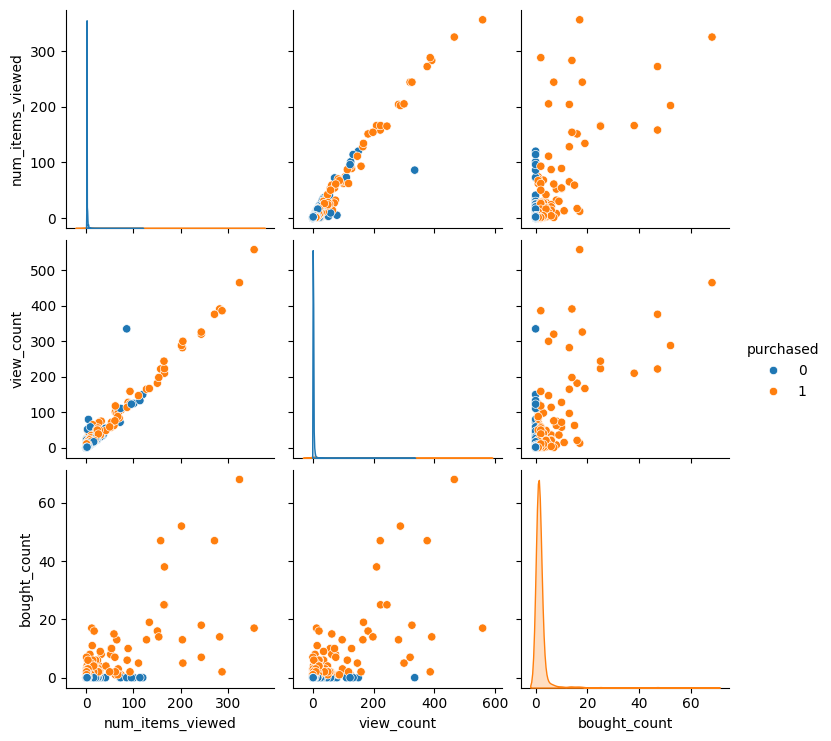

In [28]:
sns.pairplot(main_df, x_vars = ['num_items_viewed', 'view_count', 'bought_count'],
             y_vars = ['num_items_viewed', 'view_count', 'bought_count'],  hue = 'purchased');

чем выше количество просмотров, тем выше вероятность того, что посетитель что-то купит.

# Поскольку связь линейная, используем модель логистической регрессии, чтобы предсказать покупательское поведение будущих посетителей.

In [29]:
X = main_df.drop(['purchased', 'visitorid', 'bought_count'], axis = 'columns')
y = main_df.purchased

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.7)

In [31]:
logreg = LogisticRegression()

In [32]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [33]:

y_pred_class = logreg.predict(X_test)

In [34]:
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, y_pred_class)))

accuracy =  0.9666


# точность нашей модели в прогнозировании посетителей-покупателей составляет около 80%.

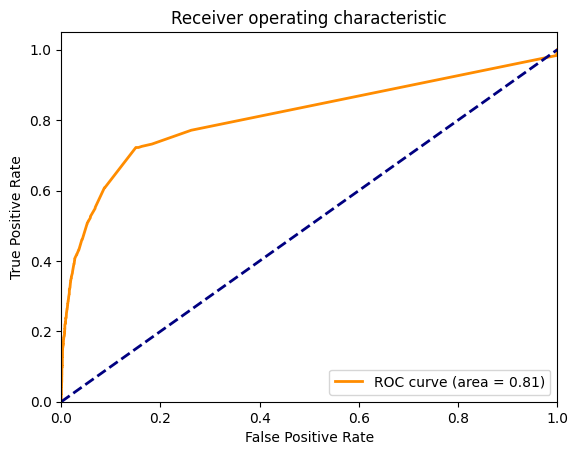

In [35]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()

На графике выше показана точность нашего бинарного классификатора (логистическая регрессия). Это просто означает, что чем ближе оранжевая кривая наклоняется к верхней левой части графика, тем выше точность.

# Распределение событий во времени для выявления закономерностей во взаимодействиях с пользователем.

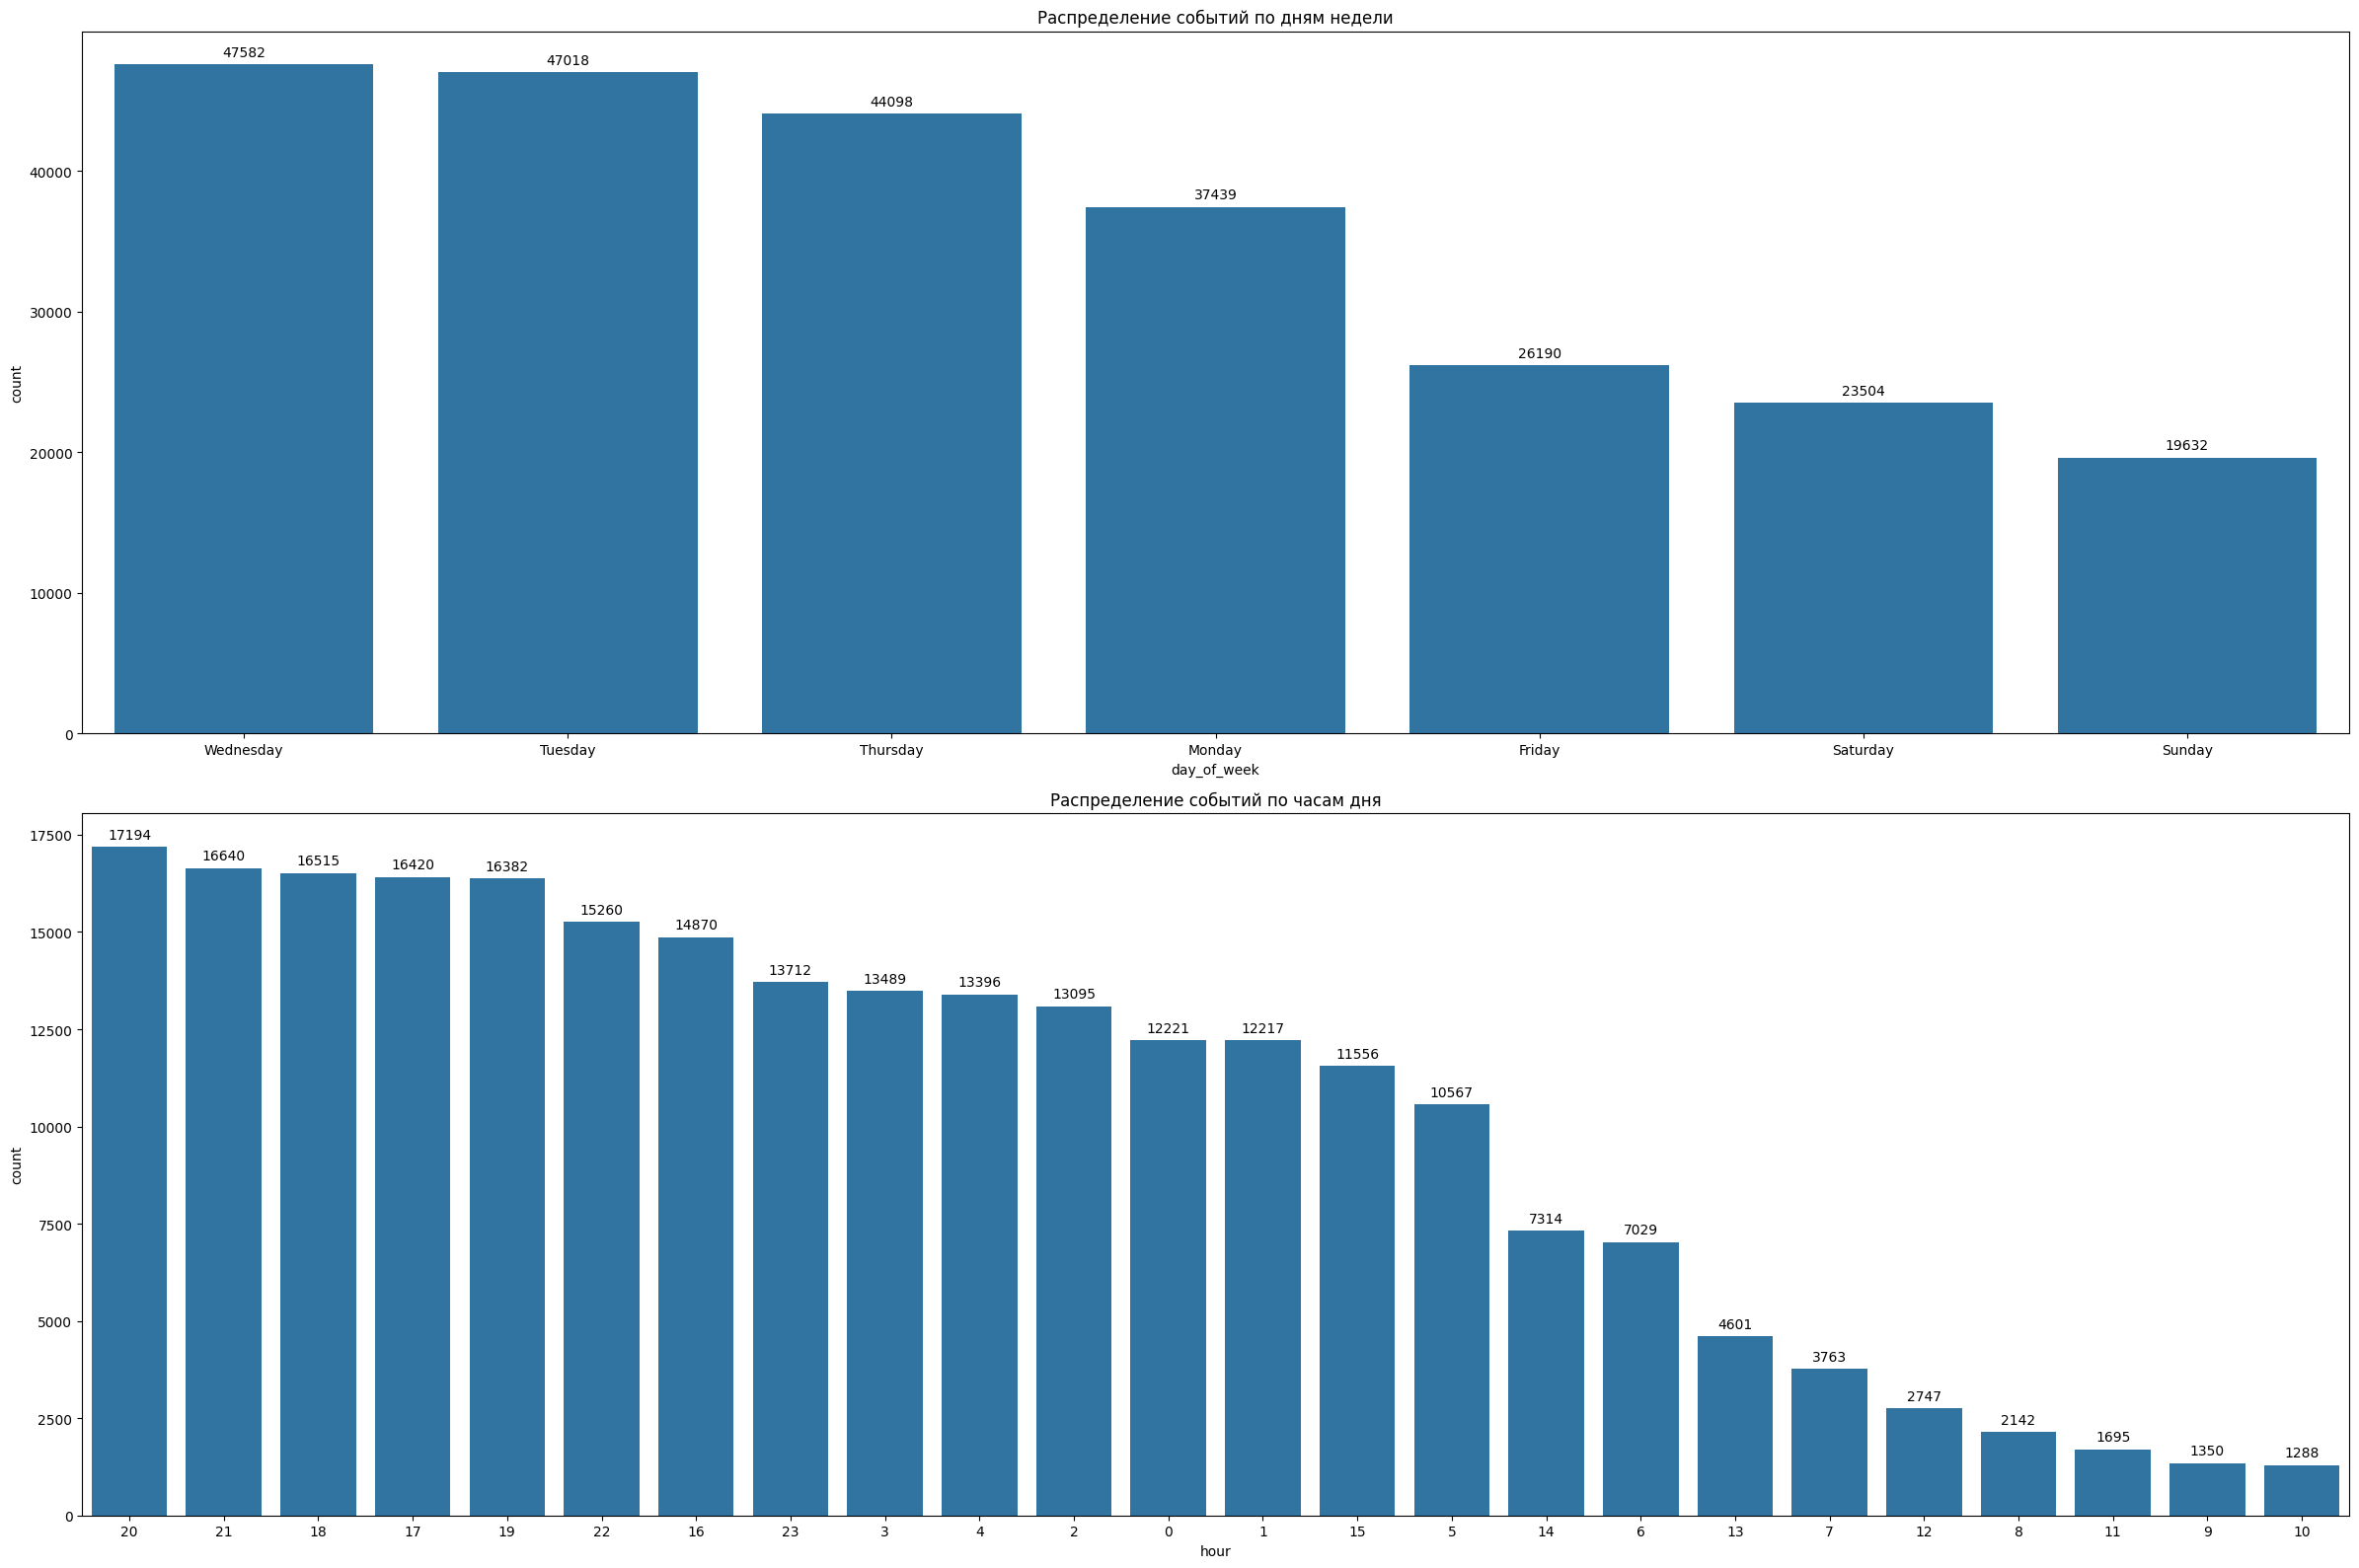

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns


events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='ms')

events_df['day_of_week'] = events_df['timestamp'].dt.day_name()
events_df['hour'] = events_df['timestamp'].dt.hour

plt.figure(figsize=(24, 16))

plt.subplot(2, 1, 1)
ax1 = sns.countplot(data=events_df, x='day_of_week', order=events_df['day_of_week'].value_counts().index)
plt.title('Распределение событий по дням недели')
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.subplot(2, 1, 2)
ax2 = sns.countplot(data=events_df, x='hour', order=events_df['hour'].value_counts().index)
plt.title('Распределение событий по часам дня')
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [37]:
events_df['transactionid'].fillna(0, inplace=True)

In [38]:
events_df['itemid'].fillna(0, inplace=True)

In [39]:
main_df.head()

,visitorid,num_items_viewed,view_count,bought_count,purchased
18027,1206412.0,1,5,0,0
27605,40581.0,1,2,0,0
21385,493562.0,1,1,0,0
7612,896062.0,1,1,0,0
1018,1397020.0,1,1,1,1


In [44]:
events_df['visitorid'].fillna(0, inplace=True)

In [45]:

user_interaction_counts = events_df.groupby('visitorid')['event'].count().reset_index()
user_interaction_counts.rename(columns={'event': 'total_events_user'}, inplace=True)

item_interaction_counts = events_df.groupby('itemid')['event'].count().reset_index()
item_interaction_counts.rename(columns={'event': 'total_events_item'}, inplace=True)

# Calculate total number of unique items interacted with by each user
user_unique_items = events_df.groupby('visitorid')['itemid'].nunique().reset_index()
user_unique_items.rename(columns={'itemid': 'unique_items_interacted'}, inplace=True)

# Calculate total number of unique users interacting with each item
item_unique_users = events_df.groupby('itemid')['visitorid'].nunique().reset_index()
item_unique_users.rename(columns={'visitorid': 'unique_users_interacted'}, inplace=True)

events_df = events_df.merge(user_interaction_counts, on='visitorid', how='left')
events_df = events_df.merge(item_interaction_counts, on='itemid', how='left')
events_df = events_df.merge(user_unique_items, on='visitorid', how='left')
events_df = events_df.merge(item_unique_users, on='itemid', how='left')

In [41]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid,day_of_week,hour,total_events_user,total_events_item,unique_items_interacted,unique_users_interacted
0,2015-06-02 05:02:12.117,257597.0,view,355908.0,0.0,Tuesday,5,2.0,3,2.0,3
1,2015-06-02 05:50:14.164,992329.0,view,248676.0,0.0,Tuesday,5,22.0,10,18.0,3
2,2015-06-02 05:13:19.827,111016.0,view,318965.0,0.0,Tuesday,5,1.0,4,1.0,4
3,2015-06-02 05:12:35.914,483717.0,view,253185.0,0.0,Tuesday,5,3.0,2,2.0,1
4,2015-06-02 05:02:17.106,951259.0,view,367447.0,0.0,Tuesday,5,1.0,12,1.0,11


Создадим матрицу действий

In [46]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

events_df['interaction_value'] = events_df['event'].apply(lambda x: 0.4 if x == 'view' else (0.6 if x == 'addtocart' else 0.8))

item_index_map = {item: idx for idx, item in enumerate(events_df['itemid'].unique())}
visitor_index_map = {visitor: idx for idx, visitor in enumerate(events_df['visitorid'].unique())}

row_indices = [visitor_index_map[visitor] for visitor in events_df['visitorid']]
col_indices = [item_index_map[item] for item in events_df['itemid']]
interaction_values = events_df['interaction_value']

interaction_matrix = csr_matrix((interaction_values, (row_indices, col_indices)),
                                 shape=(len(visitor_index_map), len(item_index_map)))

print(interaction_matrix)
# код выводит разреженную матрицу interaction_matrix,
# которая представляет собой матрицу взаимодействия между посетителями (строки) и товарами (столбцы)
# на основе значений в столбце 'interaction_value

  (0, 0)	0.4
  (0, 3415)	0.4
  (1, 1)	0.4
  (1, 2421)	0.4
  (1, 5444)	0.4
  (1, 11416)	0.4
  (1, 15434)	0.4
  (1, 22492)	0.4
  (1, 24683)	0.8
  (1, 24728)	1.2000000000000002
  (1, 31226)	0.4
  (1, 36863)	0.4
  (1, 37451)	0.4
  (1, 37950)	0.4
  (1, 37956)	0.4
  (1, 38232)	0.4
  (1, 38745)	0.8
  (1, 38934)	0.4
  (1, 50767)	0.4
  (1, 69304)	0.4
  (2, 2)	0.4
  (3, 3)	0.8
  (3, 10712)	0.4
  (4, 4)	0.4
  (5, 5)	0.4
  :	:
  (131812, 51681)	0.4
  (131813, 71003)	0.4
  (131814, 50790)	0.4
  (131815, 41906)	0.4
  (131816, 3957)	0.4
  (131817, 59204)	0.4
  (131818, 25635)	0.4
  (131819, 71004)	0.4
  (131820, 3004)	0.4
  (131821, 54)	0.4
  (131822, 39297)	0.4
  (131823, 70457)	0.4
  (131824, 2120)	0.4
  (131825, 17432)	0.4
  (131826, 5603)	0.6
  (131827, 20361)	0.4
  (131828, 3880)	0.4
  (131829, 71008)	0.4
  (131830, 71009)	0.4
  (131831, 71010)	0.4
  (131832, 3691)	0.4
  (131833, 49821)	0.4
  (131834, 1905)	0.4
  (131835, 18149)	0.4
  (131836, 71011)	0.8


In [47]:
from sklearn.metrics.pairwise import cosine_similarity

# Вычисление сходства пользователей
user_similarity = cosine_similarity(interaction_matrix)

# Создание функции для получения рекомендаций для конкретного пользователя
def get_recommendations(visitorid, num_recommendations=5):
    # Находим наиболее похожих пользователей
    similar_users = user_similarity[visitorid]
    similar_users_idx = similar_users.argsort()[::-1][1:]  # Исключаем самого пользователя

    # Получаем товары, с которыми взаимодействовали похожие пользователи
    recommendations = set()
    for similar_user_idx in similar_users_idx:
        similar_user_actions = interaction_matrix[similar_user_idx]
        new_recommendations = set(events_df.loc[similar_user_actions > 0, 'itemid'])
        recommendations.update(new_recommendations)
        if len(recommendations) >= num_recommendations:
            break

    # Исключаем товары, с которыми пользователь уже взаимодействовал
    user_actions = interaction_matrix[visitorid]
    recommendations.difference_update(set(events_df.loc[user_actions > 0, 'itemid']))

    return list(recommendations)[:num_recommendations]

In [48]:
%pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163007 sha256=198ebbaf5be1cadbb92066bbffce755d20507690e6e152d73b0abc76a7522867
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [62]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.4, 0.6, 0.8]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

best_params = gs.best_params['rmse']

In [63]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(events_df[['visitorid', 'itemid', 'interaction_value']], reader)

model = SVD(n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
cross_validate(model,  data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()
model.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0476  0.0481  0.0481  0.0485  0.0478  0.0480  0.0003  
MAE (testset)     0.0217  0.0217  0.0216  0.0218  0.0217  0.0217  0.0001  
Fit time          2.75    3.04    2.72    2.83    3.17    2.90    0.18    
Test time         0.88    0.35    0.30    0.25    0.26    0.41    0.24    


In [64]:
from surprise.dump import dump

model_filename = 'trained_model.pkl'
dump(model_filename, algo=model)

In [65]:
from surprise.dump import load

loaded_model = load(model_filename)[1]

In [66]:
def get_top_n_recommendations(model, user_id, num_items, n=10):
    recommendations = []
    for item_id in range(1, num_items + 1):
        prediction = model.predict(user_id, item_id)
        recommendations.append((item_id, prediction.est))

    # Sort recommendations by estimated rating
    recommendations.sort(key=lambda x: x[1], reverse=True)

    top_n_recommendations = recommendations[:n]
    return top_n_recommendations

user_id = 10
num_items = events_df['itemid'].nunique()
top_recommendations = get_top_n_recommendations(loaded_model, user_id, num_items, n=5)
print("Лучшие рекомендации для пользователей", user_id)
for item_id, estimated_rating in top_recommendations:
    print("Item:", item_id, "Предполагаемый рейтинг по продукту:", estimated_rating)



Лучшие рекомендации для пользователей 10
Item: 26102 Предполагаемый рейтинг по продукту: 0.48784038307888195
Item: 8641 Предполагаемый рейтинг по продукту: 0.4866372798569233
Item: 1115 Предполагаемый рейтинг по продукту: 0.48602552601157745
Item: 43392 Предполагаемый рейтинг по продукту: 0.47602249127195173
Item: 26900 Предполагаемый рейтинг по продукту: 0.4694383862498003


In [54]:
user_id = 200
num_items = events_df['itemid'].nunique()
top_recommendations = get_top_n_recommendations(loaded_model, user_id, num_items, n=10)
print("Лучшие рекомендации для пользователей", user_id)
for item_id, estimated_rating in top_recommendations:
    print("Item:", item_id, "Предполагаемый рейтинг по продукту:", estimated_rating)

Лучшие рекомендации для пользователей 200
Item: 8426 Предполагаемый рейтинг по продукту: 0.5063645079463525
Item: 8641 Предполагаемый рейтинг по продукту: 0.48311027316858124
Item: 55044 Предполагаемый рейтинг по продукту: 0.477618691492091
Item: 2142 Предполагаемый рейтинг по продукту: 0.4769331569829339
Item: 29712 Предполагаемый рейтинг по продукту: 0.4751188618534619
Item: 15822 Предполагаемый рейтинг по продукту: 0.4750045109511992
Item: 62613 Предполагаемый рейтинг по продукту: 0.47461350413567527
Item: 41539 Предполагаемый рейтинг по продукту: 0.4738821419603421
Item: 42819 Предполагаемый рейтинг по продукту: 0.47342848044567637
Item: 5250 Предполагаемый рейтинг по продукту: 0.4725307030082022


In [ ]:
#%pip install tensorflow

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow import keras


In [71]:
embedding_dim = 100


# Создание модели нейронной сети
model = keras.Sequential([
    keras.layers.Embedding(user_interaction_counts, embedding_dim, input_length=user_item_matrix.shape[1]),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

NameError: name 'user_item_matrix' is not defined

In [ ]:
data = Dataset.load_from_df(events_df[['visitorid', 'itemid', 'interaction_value']], reader)

In [ ]:
# Разделение данных на обучающий и тестовый наборы
train_data, test_data = train_test_split(events_df[['visitorid', 'itemid', 'interaction_value']], test_size=0.2, random_state=42)

# Обучение модели
history = model.fit(x=[train_data['visitorid'], train_data['itemid']], y=train_data['interaction_value'],
                    epochs=10, batch_size=64, validation_data=([test_data['visitorid'], test_data['itemid']], test_data['interaction_value']))

# Оценка модели
predictions = model.predict([test_data['visitorid'], test_data['itemid']])
mse = mean_squared_error(test_data['interaction_value'], predictions)
print(f'Mean Squared Error: {mse}')

In [ ]:
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='ms')

In [ ]:
merged_data = pd.merge(data, user_data, on='user_id').merge(item_data, on='item_id')